# Feature Engineering

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

c:\Users\agost\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

def mae(pred, value):
    return (np.abs(pred - value)).mean()
    
def rmse(pred, value):
    return np.sqrt(((pred-value)**2).mean())

## Load data

In [3]:
# Download csv file from resources and put it in working directory

calendar = pd.read_csv('../Demand Forecasting M5/calendar.csv', header=0)
sales = pd.read_csv('../Demand Forecasting M5/sales_train_evaluation.csv', header=0)
sales_val = pd.read_csv('../Demand Forecasting M5/sales_train_validation.csv', header=0)
sample_sub = pd.read_csv('../Demand Forecasting M5/sample_submission.csv', header=0)
sell_prices = pd.read_csv('../Demand Forecasting M5/sell_prices.csv', header=0)

In [4]:
d_cols = [i for i in sales.columns if 'd_' in i]  # d_1,d_2....

In [ ]:
#Add zero sales for the remaining days 1942-1969
#for d in range(1942,1970):
#    col = 'd_' + str(d)
#    sales[col] = 0
#    sales[col] = sales[col].astype(np.int16)

## Downcasting

Problem: on google collab we have 25 GB RAM and 100 GB HDD (free resources).We prefer to drop the initial 900 days of data. [https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling/notebook]

Numerical Columns: Pandas automatically creates int32, int64, float32 or float64 columns for numeric ones. If you know the min or max value of a column, you can use a subtype which is less memory consuming. You can also use an unsigned subtype if there is no negative value.
Here are the different subtypes you can use:
* int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255
* bool : consumes 1 byte, true or false
* float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535
* float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647
* float64 / int64 / uint64: consumes 8 bytes of memory

Categorical Columns: Pandas stores categorical columns as objects. One of the reason this storage is not optimal is that it creates a list of pointers to the memory address of each value of your column. For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category datatype.

In [ ]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(sell_prices.memory_usage().sum()/(1024*1024),1)
print(sales_bd)

In [ ]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

In [ ]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(sell_prices.memory_usage().sum()/(1024*1024),1)

In [ ]:
print(sales_ad)
print(sales_bd)

In [ ]:
dic = {'DataFrame':['sales','calendar','prices'],
       'Before downcasting':[sales_bd, calendar_bd, prices_bd],
       'After downcasting':[sales_ad, calendar_ad, prices_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template = 'seaborn', title = 'Effect of Downcasting')
fig.show()

## Melting the data

In this section we want to merge all the datasets: sales, calendar and sell_prices. 

In [ ]:
sales.head()

In [ ]:
sales.columns

The first thing that we want to do is to convert each row (each series) in a column.
For instance, given a row like that:

|       id	    |  d_1 | d_2   |
|---------------|:----:|------:|
| HOBBIES_1_001_CA_1_evaluation | 0 | 0 |

Becomes:

|       id	    |  d | sold   |
|---------------|:----:|------:|
| HOBBIES_1_001_CA_1_evaluation | d_1 | 0 |
| HOBBIES_1_001_CA_1_evaluation | d_2 | 0 |

We can do that with the melt function that converts the sales dataframe form a wide format to al long format.
https://towardsdatascience.com/reshape-pandas-dataframe-with-melt-in-python-tutorial-and-visualization-29ec1450bb02

We have kept the "id variables" as id, item_id, dept_id, cat_id, store_id and state_id. They have in total 30490 unique values when compunded together. Now the total number of days for which we have the data is 1941 days. Therefore the melted dataframe will be having 30490x1941 i.e. 59181090 rows

In [ ]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [ ]:
df.head()

In [ ]:
print(df.columns)
print(df.shape)

In [ ]:
calendar.shape

In [ ]:
calendar = calendar[:1942]

In [ ]:
calendar.head()


Now we can merge the previous dataframe (the melted dataframe) and the calendar dataset. They have both the column "d". We can merge on it.

In [ ]:
df = pd.merge(df, calendar, on='d', how='left')

In [ ]:
print(df.columns)
print(df.shape)

In [ ]:
sell_prices.head()

The sell_prices dataset have three columns that are also in the df dataset. We can merge the two datasets on them.

In [ ]:
df = pd.merge(df, sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [ ]:
print(df.columns)
print(df.shape)

Now we have a single and a complete dataframe with all the data required.

In [ ]:
print('Size of the dataframe: ', df.shape)
df.head()

In [ ]:
#import pickle
#with open("df.pkl", 'wb') as pickle_file:
#    pickle.dump(df, pickle_file)

## Import data

In [3]:

import pickle
with open('../Demand Forecasting M5/df.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
print(df.columns)

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')


## Features

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.
The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning algorithm to model.


### Label Encoding


Remove unwanted data to create space in RAM for further processing.

Note:
We are storing the categories correponding to their respective category codes.

In [5]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [6]:
#Store the categories along with their codes in this way can I remap each term to the original term
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))
index = ['dates', 'd_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']

In [7]:
# save the date column
dates = df.date 

In [8]:
# drop dates from the dataset

df.drop('date',axis=1,inplace=True)

In [ ]:
#import pickle

#data = [index, dates, d_id, d_item_id, d_dept_id, d_cat_id, d_store_id, d_state_id]

#with open("dict.dat", "wb") as pickle_file: # o dict.pkl
#    pickle.dump(data, pickle_file)


In [9]:
# change column 'd':
# from 'd_1' to 1 (as integer) 

df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)

In [10]:
# Convert each column that is category type in numbers

cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        

In [11]:
print(df.shape)
print(df.head())

(59181090, 21)
      id  item_id  dept_id  cat_id  store_id  state_id  d  sold  wm_yr_wk  \
0  14370     1437        3       1         0         0  1     0     11101   
1  14380     1438        3       1         0         0  1     0     11101   
2  14390     1439        3       1         0         0  1     0     11101   
3  14400     1440        3       1         0         0  1     0     11101   
4  14410     1441        3       1         0         0  1     0     11101   

   weekday  ...  month  year  event_name_1  event_type_1  event_name_2  \
0        2  ...      1  2011            -1            -1            -1   
1        2  ...      1  2011            -1            -1            -1   
2        2  ...      1  2011            -1            -1            -1   
3        2  ...      1  2011            -1            -1            -1   
4        2  ...      1  2011            -1            -1            -1   

   event_type_2  snap_CA  snap_TX  snap_WI  sell_price  
0            -1     

### Aggregation 

In [12]:
df_aggregation = df.copy()

In [13]:
df_aggregation.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price'],
      dtype='object')

In [14]:
df_aggregation = df_aggregation.set_index(pd.DatetimeIndex(dates))
#df_aggregation['date'] = dates
df_aggregation.shape

(59181090, 21)

In [15]:
df_aggregation = df_aggregation.loc[:][['id','d','dept_id', 'weekday', 'wday', 'month', 'year', 'store_id', 'sold']]
df_aggregation.shape

(59181090, 9)

In [16]:
df_aggregation.head(10)

,id,d,dept_id,weekday,wday,month,year,store_id,sold
date,,,,,,,,,
2011-01-29,14370,1,3,2,1,1,2011,0,0
2011-01-29,14380,1,3,2,1,1,2011,0,0
2011-01-29,14390,1,3,2,1,1,2011,0,0
2011-01-29,14400,1,3,2,1,1,2011,0,0
2011-01-29,14410,1,3,2,1,1,2011,0,0
2011-01-29,14420,1,3,2,1,1,2011,0,0
2011-01-29,14430,1,3,2,1,1,2011,0,0
2011-01-29,14440,1,3,2,1,1,2011,0,12
2011-01-29,14450,1,3,2,1,1,2011,0,2


In [17]:
df_aggregation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59181090 entries, 2011-01-29 to 2016-05-22
Data columns (total 9 columns):
 #   Column    Dtype
---  ------    -----
 0   id        int16
 1   d         int16
 2   dept_id   int8 
 3   weekday   int8 
 4   wday      int8 
 5   month     int8 
 6   year      int16
 7   store_id  int8 
 8   sold      int16
dtypes: int16(4), int8(5)
memory usage: 1.2 GB


In [18]:
print(d_dept_id)
print()
print()
print(d_store_id)

{3: 'HOBBIES_1', 4: 'HOBBIES_2', 5: 'HOUSEHOLD_1', 6: 'HOUSEHOLD_2', 0: 'FOODS_1', 1: 'FOODS_2', 2: 'FOODS_3'}


{0: 'CA_1', 1: 'CA_2', 2: 'CA_3', 3: 'CA_4', 4: 'TX_1', 5: 'TX_2', 6: 'TX_3', 7: 'WI_1', 8: 'WI_2', 9: 'WI_3'}


In [19]:
#take only da dept 2 and store 2
df_aggregation = df_aggregation[(df_aggregation.dept_id == 2) & (df_aggregation.store_id == 2)]
df_aggregation.head()

,id,d,dept_id,weekday,wday,month,year,store_id,sold
date,,,,,,,,,
2011-01-29,6142,1,2,2,1,1,2011,2,4
2011-01-29,6152,1,2,2,1,1,2011,2,0
2011-01-29,6162,1,2,2,1,1,2011,2,0
2011-01-29,6172,1,2,2,1,1,2011,2,0
2011-01-29,6182,1,2,2,1,1,2011,2,1


Prendiamo solo i prodotti dello store CA_3 relativi al FOODS_3 che sono lo store e la categoria con più vendite

In [20]:
df_aggregation.shape

(1597443, 9)

In [21]:
#remove the period in which the product is not sold
# remove over 20 days of zeros

#create index to remove:
def remove_zeros(df, starts_ends):
    row = df.copy()

    for el in starts_ends:
        start, end = el
        #print(start, end)

        index_start = row.index.get_loc(start)
        #print(index_start)

        index_end = row.index.get_loc(end)

        #print(df.index[index_start : index_end +1])
        #print(slice_remove)
        row.drop(row.index[index_start : index_end ], axis=0, inplace=True)
        #print(row)

    return row

def remove_nan(aggregated, index):
    agg = aggregated[index].dropna(inplace=False)
    return agg





In [22]:
ids = df_aggregation.id.unique().tolist()
dat = df_aggregation.index.unique().tolist()

In [23]:
df_aggregation['year'] = df_aggregation.index.year
df_aggregation['month'] = df_aggregation.index.month
df_aggregation['day'] = df_aggregation.index.day

In [24]:

from datetime import datetime, timedelta
import pandas as pd

mean_all_products = []# = df_aggregation.groupby("id")['sold'].mean()
#print(mean_all_products.loc[mean_all_products == mean_all_products.max()]) find max mean
mean_all_aggregations_s = []
mean_all_aggregations_m = []


total_dict_mean = {}
total_dict_sum = {}
to_remove = []
starts_ends_dict = {}

for prod in ids:
    #take values no zeros
    produ = df_aggregation[df_aggregation.id == prod]
    produ_no_zero = produ[produ.sold > 0]
    produ_no_zero['date'] = produ_no_zero.index
    produ_no_zero.index = range(produ_no_zero.shape[0])


    one_day = timedelta(days = 1)
    starts_ends = []

    first_day = df_aggregation.index[0]

    if first_day not in produ_no_zero['date']:
        first_gap = produ_no_zero['date'][0] + one_day - first_day
        gap_start = first_day
        gap_end = produ_no_zero['date'][0]

        if first_gap.to_pytimedelta().days > 14:
            starts_ends.append((str(gap_start)[:10], str(gap_end)[:10]))
            #print('First gap', gap_start, ' until ', gap_end, 'Duration: ', str(first_gap.to_pytimedelta() -one_day))

    deltas = produ_no_zero['date'].diff()[1:]


    gaps = deltas[deltas > timedelta(days=1)]



    # Print results
    #print(f'{len(gaps)} gaps with average gap duration: {gaps.mean()}')


    for i, g in gaps.iteritems():
        gap_start = produ_no_zero['date'][i -1]
        gap_start = gap_start + one_day

        gap_end = gap_start + g.to_pytimedelta() -one_day #remember to remove the date without one at the end
        #print(gap_start, gap_end)
        if g.to_pytimedelta().days > 14:
            starts_ends.append((str(gap_start)[:10], str(gap_end)[:10]))
            #print(gap_start, ' until ', gap_end, 'Duration: ', str(g.to_pytimedelta() -one_day))
            starts_ends_dict[prod] = starts_ends
    
    prod_no_zero = remove_zeros(produ, starts_ends)

    # calcolo la media delle vendite di questo prodotto
    
    mean = prod_no_zero['sold'].mean().astype(np.float16)
    dev = prod_no_zero['sold'].std().astype(np.float16)
    # mean_all_products salva il nome del prodotto e la sua media totale, avendo già tolto i valori nulli da non considerare
    mean_all_products.append((prod, mean, dev))
    #windows = [2,3,4,7,14,28,56,70,84]

    windows = [el for el in range(1,25)]


    d_sum = {}
    for x in windows:
        d_sum['%dD' %x] = x

    d_mean = {}
    for x in windows:
        d_mean['%dD' %x] = x


    cs = {}
    for el in d_mean:
        #print(el)
        #if prod == 6142:
        #    print(prod_no_zero.groupby('id')['sold'].resample('%dD' % d_mean[el]).mean().astype(np.float16))
        #    print('new')
        #    print(prod_no_zero['sold'].resample('%dD' % d_mean[el]).mean().astype(np.float16))
    
        agg = prod_no_zero.groupby('id')['sold'].resample('%dD' % d_mean[el]).mean().astype(np.float16)

        if agg.isna().sum() != 0:
            c = agg[agg.isna()]
            c = c[prod].index
            cs[el] = c
        d_mean[el] = remove_nan(agg, prod)

        if d_mean[el].mean().astype(np.float16) != np.inf:
            mean_all_aggregations_m.append((prod, el, d_mean[el].mean().astype(np.float16), d_mean[el].std().astype(np.float16)))
        else:
            to_remove.append(prod)



    for  el in d_sum:
        aggr = prod_no_zero.groupby('id')['sold'].resample('%dD' % d_sum[el]).sum().astype(np.float16)


        if el in cs:
            cx = cs[el]
            aggr = aggr[prod].drop(cx)
            

        d_sum[el] = aggr.dropna(inplace=False)

        if d_sum[el].mean().astype(np.float16) != np.inf:
            mean_all_aggregations_s.append((prod, el, d_sum[el].mean().astype(np.float16), d_sum[el].std().astype(np.float16)))
        else:
            to_remove.append(prod)
        #mean = d_sum[el].groupby("id")['sold'].mean()[prod]
    
    keep = True
    for el in d_mean:
        if len(d_mean[el])<3:
            #print(el)
            to_remove.append(prod)
            keep = False
            break

    #print(mean_all_aggregations_m)
    
    if prod in to_remove:
        #print(prod)
        keep = False    
       


    if keep:
        total_dict_mean[prod] = d_mean
        total_dict_sum[prod] = d_sum


In [34]:
'''
c_ovs= 5 # Cost of over stock (waste)
c_oos = 3 # Cost of out of stock 

# A simple cost model
cost = c_ovs * len(fp) + c_oos * len(fn) 
'''

'\nc_ovs= 5 # Cost of over stock (waste)\nc_oos = 3 # Cost of out of stock \n\n# A simple cost model\ncost = c_ovs * len(fp) + c_oos * len(fn) \n'

In [ ]:
'''import pickle
with open("total_dict_mean.pkl", 'wb') as pickle_file:
    pickle.dump(total_dict_mean, pickle_file)
with open("total_dict_sum.pkl", 'wb') as pickle_file:
    pickle.dump(total_dict_sum, pickle_file)
'''

In [ ]:
'''import pickle
with open('../Demand Forecasting M5/total_dict_mean.pkl', 'rb') as f:
    total_dict_mean = pickle.load(f)
'''

In [25]:
# update indexis because we have removed some products
ids_mean = [el for el in total_dict_mean]
ids_sum = [el for el in total_dict_sum]


In [26]:
mean_all_products = pd.DataFrame(mean_all_products, columns =['id', 'm', 'dev'])

#ci servono per vedere se sono simili i prodotti

mean_all_aggregations_mean = pd.DataFrame(mean_all_aggregations_m, columns = ['id', 'aggregation', 'm', 'dev'])
mean_all_aggregations_sum = pd.DataFrame(mean_all_aggregations_s, columns = ['id', 'aggregation', 'm', 'dev'])

In [27]:
to_remove = set(to_remove)
to_remove = list(to_remove)
print(to_remove)
mean_all_aggregations_mean = mean_all_aggregations_mean[~mean_all_aggregations_mean.id.isin(to_remove)]
mean_all_aggregations_sum = mean_all_aggregations_sum[~mean_all_aggregations_sum.id.isin(to_remove)]
mean_all_products = mean_all_products[~mean_all_products.id.isin(to_remove)]


[8642, 11532, 11982, 7022, 11992, 7322, 14172, 12472]


In [28]:
mean_all_products.head()

,id,m,dev
0,6142,1.455078,2.074219
1,6152,2.939453,2.679688
2,6162,2.234375,1.888672
3,6172,0.554199,1.004883
4,6182,1.135742,1.368164


In [29]:
mean_all_aggregations_mean[mean_all_aggregations_mean.id == 6142].head()

,id,aggregation,m,dev
0,6142,1D,1.455078,2.074219
1,6142,2D,1.470703,1.583008
2,6142,3D,1.460938,1.242188
3,6142,4D,1.483398,1.148438
4,6142,5D,1.482422,1.049805


In [30]:
#mean_all_aggregations_mean [mean_all_aggregations_mean.m == mean_all_aggregations_mean.m.max()]

mean_all_aggregations_mean.m.describe()

count    1.956000e+04
mean              inf
std      5.191406e+00
min      2.446289e-01
25%      1.144287e+00
50%      2.100586e+00
75%      4.003906e+00
max      4.140625e+01
Name: m, dtype: float64

In [31]:
print('number of products considered', len(total_dict_mean))
print('number of aggregations', len(total_dict_mean[ids[0]]))

number of products considered 815
number of aggregations 24


In [32]:
'''
import plotly.offline as py

trace = go.Histogram(
    x=mean_all_aggregations_mean[ mean_all_aggregations_mean.id == 9302].m
)

py.iplot([trace], filename='normality-histogram')
'''

"\nimport plotly.offline as py\n\ntrace = go.Histogram(\n    x=mean_all_aggregations_mean[ mean_all_aggregations_mean.id == 9302].m\n)\n\npy.iplot([trace], filename='normality-histogram')\n"

In [33]:
mean_all_products.describe()

,id,m,dev
count,815.000000,815.000000,815.000000
mean,10248.171779,3.896484,3.462891
std,2376.111057,5.234375,4.003906
min,6142.000000,0.244629,0.541992
25%,8197.000000,1.148438,1.406250
50%,10242.000000,2.117188,2.208984
75%,12307.000000,4.035156,3.648438
max,14362.000000,41.406250,36.437500


In [34]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =mean_all_products
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.24462890625
10 percentile value is 1.0302734375
20 percentile value is 1.455078125
30 percentile value is 1.962890625
40 percentile value is 2.591796875
50 percentile value is 3.82421875
60 percentile value is 7.83984375
70 percentile value is 6952.0
80 percentile value is 9432.0
90 percentile value is 11882.0
100 percentile value is  14362.0


##### All the products

In [35]:
starts_ends_dict[ids[0]]

[('2011-04-02', '2011-04-23'),
 ('2012-05-16', '2012-08-12'),
 ('2012-10-03', '2012-10-18'),
 ('2013-05-02', '2013-07-27'),
 ('2013-07-28', '2013-09-10'),
 ('2013-09-23', '2013-10-08'),
 ('2014-04-17', '2014-07-20'),
 ('2014-07-21', '2014-08-20'),
 ('2015-01-11', '2015-01-25'),
 ('2015-05-09', '2015-06-11'),
 ('2015-06-12', '2015-09-11')]

In [38]:
import plotly.offline as py

trace = go.Histogram(
    x=total_dict_sum[ids[0]]['2D']
)

py.iplot([trace], filename='normality-histogram')

#### We want to choose the products that have a similar distribution. So firstly we can consider the products that have similar mean.

In [39]:
prod_0_mean = mean_all_products[mean_all_products.id == ids[0]].m
prod_0_dev = mean_all_products[mean_all_products.id == ids[0]].dev
prod_0_mean = list(prod_0_mean)[0]
prod_0_dev = list(prod_0_dev)[0]

#### Find list of similar product based on the mean and standard deviation, before the aggregation

In [40]:
list_similar_product = list(mean_all_products[(mean_all_products.m >= prod_0_mean*0.9) & (mean_all_products.m <= prod_0_mean*1.10) & (mean_all_products.dev >= prod_0_dev*0.95) & (mean_all_products.dev <= prod_0_dev*1.05)].id)
list_similar_product

[6142, 6282, 7352, 11912, 12172, 13432]

In [ ]:
#list_dev_index = list(std_dev[ (mean_all_products.m >= std_dev[6142]*0.95) & (std_dev <= std_dev[6142]*1.05) ].index)
#print(list_dev_index)

In [41]:
batch_with_date = {}
for el in list_similar_product:

    for d in total_dict_sum[el]: #d = key 2D

        if d not in batch_with_date:
            batch_with_date[d] = [total_dict_sum[el][d]] #list(total_dict_mean[el][d].values)
            
        else:
            batch_with_date[d].append(total_dict_sum[el][d])



batch = {}
for el in list_similar_product:
    for d in total_dict_sum[el]: #d = key 2D
        if d not in batch:
            batch[d] = list(total_dict_sum[el][d].values)
        else:
            batch[d].extend(total_dict_sum[el][d])


#print(len(batch['14D']))
#counter = 0
#for el in list_similar_product:
#    print(len(total_dict_mean[el]['14D']))
#    counter += len(total_dict_mean[el]['14D'])
#print(counter)

In [42]:
len(batch['2D'])

3995

In [45]:
import plotly.offline as py

trace = go.Histogram(
    x=total_dict_sum[ids[0]]['1D']
)

py.iplot([trace], filename='normality-histogram')

In [46]:
import plotly.offline as py

trace = go.Histogram(
    x=batch['7D']
)

py.iplot([trace], filename='normality-histogram')

In [48]:
from scipy.stats import shapiro
import plotly.figure_factory as ff
stat, p = shapiro(total_dict_sum[ids[0]]['2D'])
print(stat,p)

0.7530447244644165 2.8870021355771597e-31


In [49]:
from scipy.stats import shapiro
import plotly.figure_factory as ff

list_stat = []


for d in batch:
    stat, p = shapiro(batch[d])
    list_stat.append((d, stat, p))


statistics = pd.DataFrame(data = list_stat, columns= ['agg', 'stat', 'p'])

#stat, p = shapiro(total_dict_mean['35D'])

# interpret

alpha = 0.05
if p > alpha:
    msg = 'Sample looks Gaussian (fail to reject H0)'
else:
    msg = 'Sample does not look Gaussian (reject H0)'

result_mat = [
    ['Length of the sample data', 'Test Statistic', 'p-value', 'Comments'],
    [len(batch['14D']), stat, p, msg]
]

swt_table = ff.create_table(result_mat)
swt_table['data'][0].colorscale=[[0, '#2a3f5f'],[1, '#ffffff']]
swt_table['layout']['height']=200
swt_table['layout']['margin']['t']=50
swt_table['layout']['margin']['b']=50

py.iplot(swt_table, filename='shapiro-wilk-table')

In [50]:
print(statistics)

    agg      stat             p
0    1D  0.701429  0.000000e+00
1    2D  0.775384  0.000000e+00
2    3D  0.805161  0.000000e+00
3    4D  0.807187  5.044674e-44
4    5D  0.807167  1.995099e-40
5    6D  0.802433  5.598453e-38
6    7D  0.798142  4.963560e-36
7    8D  0.799955  5.060099e-34
8    9D  0.809075  8.580649e-32
9   10D  0.804595  7.600653e-31
10  11D  0.800906  7.855525e-30
11  12D  0.795309  3.718125e-29
12  13D  0.811362  2.699893e-27
13  14D  0.802040  5.614046e-27
14  15D  0.808226  8.246252e-26
15  16D  0.807315  3.623682e-25
16  17D  0.816134  4.937069e-24
17  18D  0.808637  7.971363e-24
18  19D  0.802838  1.274390e-23
19  20D  0.813793  1.424311e-22
20  21D  0.820173  1.239928e-21
21  22D  0.810504  1.070671e-21
22  23D  0.822608  1.033579e-20
23  24D  0.818064  1.997614e-20


In [51]:
val = [ 0.05 for el in windows]

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x = windows, y = statistics.p, name = 'p'))
fig1.add_trace(go.Scatter(x = windows, y = statistics.stat, name = 'stat'))
fig1.add_trace(go.Scatter(x = windows, y = val, name = '0.05'))
fig1.update_layout(title = 'P and stat - 2 a 84 giorni di aggregazione', title_x = 0.5, xaxis_title = 'aggregations', yaxis_title = 'values')
fig1.show()

### List of similar products based ON AGGREGATION


In [52]:
mean_all_aggregations_mean.head()

,id,aggregation,m,dev
0,6142,1D,1.455078,2.074219
1,6142,2D,1.470703,1.583008
2,6142,3D,1.460938,1.242188
3,6142,4D,1.483398,1.148438
4,6142,5D,1.482422,1.049805


In [55]:
id_tot =  list(mean_all_aggregations_mean.id.unique())
aggr_tot = list(mean_all_aggregations_mean.aggregation.unique())

lis = []
for el in aggr_tot[:35]:
    #take the df related at similar aggregations
    me_agg = mean_all_aggregations_mean[mean_all_aggregations_mean.aggregation == el]
    prod_0_mean = list(me_agg[me_agg.id == ids[0]].m)[0]
    prod_0_dev = list(me_agg[me_agg.id == ids[0]].dev)[0]

    l = list(me_agg[(me_agg.m >= prod_0_mean*0.95) & (me_agg.m <= prod_0_mean*1.05) & (me_agg.dev >= prod_0_dev*0.98) & (me_agg.dev <= prod_0_dev*1.02)].id)
    lis.append(l)


In [56]:
print(lis)

[[6142], [6142, 6402], [6142], [6142, 8012, 8232], [6142, 8232], [6142, 7042, 8232], [6142, 7312, 14002], [6142, 7172, 8982], [6142, 8232], [6142, 7042, 8232], [6142, 7172], [6142, 7172, 8812, 13332], [6142, 7172, 14352], [6142, 6322], [6142, 7172], [6142], [6142, 8232], [6142, 6322, 12962], [6142, 8012], [6142], [6142, 7862, 8812, 9372, 14352], [6142, 8012, 8232, 8582, 14352], [6142, 7402], [6142, 7692]]


In [57]:
from collections import Counter

count = Counter(x for xs in lis for x in set(xs))
print(count)

idxs = []
for el in count.most_common(3):
    idxs.append(el[0])

print(idxs)

Counter({6142: 24, 8232: 7, 7172: 5, 8012: 3, 14352: 3, 7042: 2, 8812: 2, 6322: 2, 6402: 1, 7312: 1, 14002: 1, 8982: 1, 13332: 1, 12962: 1, 7862: 1, 9372: 1, 8582: 1, 7402: 1, 7692: 1})
[6142, 8232, 7172]


In [58]:
batch_with_date = {}
for el in idxs:

    for d in total_dict_mean[el]: #d = key 2D

        if d not in batch_with_date:
            batch_with_date[d] = [total_dict_mean[el][d]] #list(total_dict_mean[el][d].values)
            
        else:
            batch_with_date[d].append(total_dict_mean[el][d])



batch = {}
for el in idxs:
    for d in total_dict_mean[el]: #d = key 2D
        if d not in batch:
            batch[d] = list(total_dict_mean[el][d].values)
        else:
            batch[d].extend(total_dict_mean[el][d])


#print(len(batch['14D']))
#counter = 0
#for el in list_similar_product:
#    print(len(total_dict_mean[el]['14D']))
#    counter += len(total_dict_mean[el]['14D'])
#print(counter)

In [60]:
from scipy.stats import shapiro
import plotly.figure_factory as ff

list_stat = []


for d in batch:
    stat, p = shapiro(batch[d])
    list_stat.append((d, stat, p))


st = pd.DataFrame(data = list_stat, columns= ['agg', 'stat', 'p'])

#stat, p = shapiro(total_dict_mean['35D'])

# interpret

alpha = 0.05
if p > alpha:
    msg = 'Sample looks Gaussian (fail to reject H0)'
else:
    msg = 'Sample does not look Gaussian (reject H0)'

result_mat = [
    ['Length of the sample data', 'Test Statistic', 'p-value', 'Comments'],
    [len(batch['14D']), stat, p, msg]
]

swt_table = ff.create_table(result_mat)
swt_table['data'][0].colorscale=[[0, '#2a3f5f'],[1, '#ffffff']]
swt_table['layout']['height']=200
swt_table['layout']['margin']['t']=50
swt_table['layout']['margin']['b']=50

py.iplot(swt_table, filename='shapiro-wilk-table')

In [61]:
st

,agg,stat,p
0,1D,0.740313,0.000000e+00
1,2D,0.800929,9.809089e-45
2,3D,0.844767,1.146261e-34
3,4D,0.820056,1.592349e-32
4,5D,0.828482,6.075127e-29
5,6D,0.865626,5.686866e-24
6,7D,0.790405,4.461439e-27
7,8D,0.845933,3.392174e-22
8,9D,0.887225,4.876911e-18
9,10D,0.792613,6.410580e-23


In [62]:
val = [ 0.05 for el in windows]

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x = windows, y = st.p, name = 'p'))
fig1.add_trace(go.Scatter(x = windows, y = st.stat, name = 'stat'))
fig1.add_trace(go.Scatter(x = windows, y = val, name = '0.05'))
fig1.update_layout(title = 'P and stat - 2 a 84 giorni di aggregazione', title_x = 0.5, xaxis_title = 'aggregations', yaxis_title = 'values')
fig1.show()

#### NO- asfaf


In [ ]:
plt.figure(figsize=[20, 7.5]) # Impostare le dimensioni per la figura
# Consideriamo solo i dati dell'anno 1950 
X = total_dict_mean[ids[0]]['14D'].index
y = total_dict_mean[ids[0]]['14D']
sns.scatterplot(x=X, y=y)
plt.title('vendite settimanali')
plt.ylabel('scatterplot')
plt.xlabel('Anno')

In [ ]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =total_dict_mean[ids[0]]
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

In [ ]:
from scipy.stats import shapiro

In [ ]:
from scipy.stats import shapiro
import plotly.figure_factory as ff

list_stat = []


for idx in total_dict_mean:

    print(idx)
    for d in total_dict_mean[idx]:
        stat, p = shapiro(total_dict_mean[idx][d])
        list_stat.append((idx, d, stat, p))


statistics = pd.DataFrame(data = list_stat, columns= ['id','agg', 'stat', 'p'])

#stat, p = shapiro(total_dict_mean['35D'])

# interpret
alpha = 0.05
if p > alpha:
    msg = 'Sample looks Gaussian (fail to reject H0)'
else:
    msg = 'Sample does not look Gaussian (reject H0)'

result_mat = [
    ['Length of the sample data', 'Test Statistic', 'p-value', 'Comments'],
    [len(total_dict_mean[ids[0]]['28D']), stat, p, msg]
]

swt_table = ff.create_table(result_mat)
swt_table['data'][0].colorscale=[[0, '#2a3f5f'],[1, '#ffffff']]
swt_table['layout']['height']=200
swt_table['layout']['margin']['t']=50
swt_table['layout']['margin']['b']=50

py.iplot(swt_table, filename='shapiro-wilk-table')

In [ ]:
first = statistics[statistics.id == 6142]
first.head()



In [ ]:
val = [ 0.05 for el in windows]

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x = windows, y = first.p, name = 'p'))
fig1.add_trace(go.Scatter(x = windows, y = first.stat, name = 'stat'))
fig1.add_trace(go.Scatter(x = windows, y = val, name = '0.05'))
fig1.update_layout(title = 'P and stat - 2 a 84 giorni di aggregazione', title_x = 0.5, xaxis_title = 'aggregations', yaxis_title = 'values')
fig1.show()

In [ ]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x = windows[:35], y = first.p[:35], name = 'p'))
fig1.add_trace(go.Scatter(x = windows[:35], y = first.stat[:35], name = 'stat'))
fig1.add_trace(go.Scatter(x = windows[:35], y = val[:35], name = '0.05'))
fig1.update_layout(title = 'P and stat - 2 a 35 giorni di aggregazione', title_x = 0.5, xaxis_title = 'aggregations', yaxis_title = 'values')
fig1.show()

Now we can repeat for all the elements. We have basically two approacches:
1. Prendo tutti i dati. Divido i dati in cluster in base alle loro medie di vendite. Prendo un cluster e calcolo le distribuzioni. Verifico che abbiano delle distribuzioni con media simile. Li aggrego in una pool di dati ottenendo quindi una gaussiana.
2. Prendo tutti i dati, calcolo le distribuzioni per ogni elemento e per ogni tipo di aggregazione. Ottengo le medie e prendo i campioni con medie simili (cluster). Li aggrego.

#### NO- First Product

In [67]:
#print(ids[0])
product = ids[0]
first_prod = df_aggregation[df_aggregation.id == product]
#print(first_prod)
#first_prod.sold.plot()

# We can understand where is the problem
#rolling_sold_mean_7 = first_prod.groupby('id')['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
#rolling_sold_mean_7 = rolling_sold_mean_7[8:]
#rolling_sold_mean_7.plot()

date_with_value = first_prod[first_prod.sold > 0]
date_with_value['year'] = date_with_value.index.year
date_with_value['month'] = date_with_value.index.month
date_with_value['day'] = date_with_value.index.day
date_with_value.shape
date_with_value.head()

date_with_value_2 = date_with_value.copy()
date_with_value_2['date'] = date_with_value.index
date_with_value_2.index = range(date_with_value_2.shape[0])
date_with_value_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        840 non-null    int16         
 1   d         840 non-null    int16         
 2   dept_id   840 non-null    int8          
 3   weekday   840 non-null    int8          
 4   wday      840 non-null    int8          
 5   month     840 non-null    int64         
 6   year      840 non-null    int64         
 7   store_id  840 non-null    int8          
 8   sold      840 non-null    int16         
 9   day       840 non-null    int64         
 10  date      840 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int16(3), int64(3), int8(4)
memory usage: 34.6 KB


In [68]:
from datetime import datetime, timedelta
import pandas as pd



starts_ends = []

first_day = df_aggregation.index[0]
#print(first_day)
if first_day not in date_with_value_2['date']:
    print(first_day)
    first_gap = date_with_value_2['date'][0] + one_day - first_day
    print(first_gap)
    gap_start = first_day
    gap_end = date_with_value_2['date'][0]
    if first_gap.to_pytimedelta().days > 20:
        starts_ends.append((str(gap_start)[:10], str(gap_end)[:10]))
        print('First gap', gap_start, ' until ', gap_end, 'Duration: ', str(first_gap.to_pytimedelta() -one_day))

deltas = date_with_value_2['date'].diff()[1:]
#print(deltas)
# Filter diffs (here days > 1, but could be seconds, hours, etc)
gaps = deltas[deltas > timedelta(days=1)]

one_day = timedelta(days = 1)


# Print results
print(f'{len(gaps)} gaps with average gap duration: {gaps.mean()}')



for i, g in gaps.iteritems():
    gap_start = date_with_value_2['date'][i -1]
    gap_start = gap_start + one_day

    gap_end = gap_start + g.to_pytimedelta() -one_day #remember to remove the date without one at the end
    
    if g.to_pytimedelta().days > 20:
        starts_ends.append((str(gap_start)[:10], str(gap_end)[:10]))
        print(gap_start, ' until ', gap_end, 'Duration: ', str(g.to_pytimedelta() -one_day))


2011-01-29 00:00:00
1 days 00:00:00
320 gaps with average gap duration: 4 days 10:34:30
2011-04-02 00:00:00  until  2011-04-23 00:00:00 Duration:  21 days, 0:00:00
2012-05-16 00:00:00  until  2012-08-12 00:00:00 Duration:  88 days, 0:00:00
2013-05-02 00:00:00  until  2013-07-27 00:00:00 Duration:  86 days, 0:00:00
2013-07-28 00:00:00  until  2013-09-10 00:00:00 Duration:  44 days, 0:00:00
2014-04-17 00:00:00  until  2014-07-20 00:00:00 Duration:  94 days, 0:00:00
2014-07-21 00:00:00  until  2014-08-20 00:00:00 Duration:  30 days, 0:00:00
2015-05-09 00:00:00  until  2015-06-11 00:00:00 Duration:  33 days, 0:00:00
2015-06-12 00:00:00  until  2015-09-11 00:00:00 Duration:  91 days, 0:00:00


In [69]:
first_prod_zero = remove_zeros(first_prod, starts_ends)
first_prod_zero

,id,d,dept_id,weekday,wday,month,year,store_id,sold,day
date,,,,,,,,,,
2011-01-29,6142,1,2,2,1,1,2011,2,4,29
2011-01-30,6142,2,2,3,2,1,2011,2,1,30
2011-01-31,6142,3,2,1,3,1,2011,2,1,31
2011-02-01,6142,4,2,5,4,2,2011,2,0,1
2011-02-02,6142,5,2,6,5,2,2011,2,1,2
...,...,...,...,...,...,...,...,...,...,...
2016-05-18,6142,1937,2,6,5,5,2016,2,6,18
2016-05-19,6142,1938,2,4,6,5,2016,2,6,19
2016-05-20,6142,1939,2,0,7,5,2016,2,2,20


In [70]:

def remove_nan(aggregated, index):
    agg = aggregated[index].dropna(inplace=False)
    return agg


#windows = [2,3,4,7,14,28,56,70,84]

windows = [el for el in range(2,85)]


d_sum = {}
for x in windows:
    d_sum['%dD' %x] = x

d_mean = {}
for x in windows:
    d_mean['%dD' %x] = x


for el in d_sum:
    #print(el)
    agg = first_prod_zero.groupby('id')['sold'].resample('%dD' % d_sum[el] ).sum().astype(np.float16)
    d_sum[el] = remove_nan(agg, product)

for el in d_mean:
    #print(el)
    agg = first_prod_zero.groupby('id')['sold'].resample('%dD' % d_mean[el]  ).mean().astype(np.float16)
    d_mean[el] = remove_nan(agg, product)


print(d_sum.keys())

d_list = list(d_sum.keys())




dict_keys(['2D', '3D', '4D', '5D', '6D', '7D', '8D', '9D', '10D', '11D', '12D', '13D', '14D', '15D', '16D', '17D', '18D', '19D', '20D', '21D', '22D', '23D', '24D', '25D', '26D', '27D', '28D', '29D', '30D', '31D', '32D', '33D', '34D', '35D', '36D', '37D', '38D', '39D', '40D', '41D', '42D', '43D', '44D', '45D', '46D', '47D', '48D', '49D', '50D', '51D', '52D', '53D', '54D', '55D', '56D', '57D', '58D', '59D', '60D', '61D', '62D', '63D', '64D', '65D', '66D', '67D', '68D', '69D', '70D', '71D', '72D', '73D', '74D', '75D', '76D', '77D', '78D', '79D', '80D', '81D', '82D', '83D', '84D'])


In [ ]:
'''
plt.figure(figsize=[20, 7.5]) # Impostare le dimensioni per la figura
# Consideriamo solo i dati dell'anno 1950 
X = mean_7D.index.levels[1]
y = mean_7D[ids[0]]
sns.scatterplot(x=X, y=y)
plt.title('vendite settimanali')
plt.ylabel('scatterplot')
plt.xlabel('Anno') '''

### Weekday
    

<AxesSubplot:>

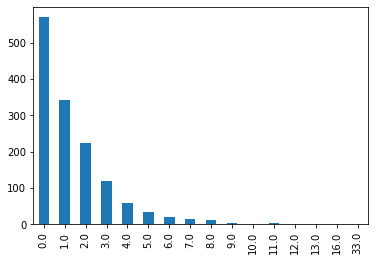

In [63]:
aasd = total_dict_sum[ids[0]]['1D'].value_counts(sort = False).sort_index()
aasd.plot.bar()

1.455


<AxesSubplot:>

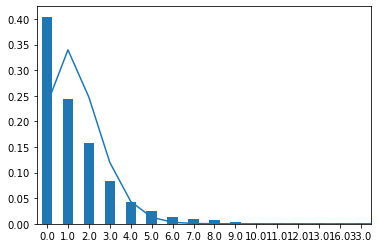

In [92]:
from scipy import stats
from scipy.stats import poisson

# nella distribuzione quante volte compare lo 0 per esempio

tmp = total_dict_sum[ids[0]]['1D']
tmpv = tmp.value_counts(sort = False , normalize = True).sort_index()


mu = tmp.mean()
print(mu)
dist = stats.poisson(mu)

#print(dist)
x = np.arange(tmp.min(), tmp.max() +1)
#print(x)

tmpv.plot.bar()
series=pd.Series(index=x, data=dist.pmf(x))
series.plot()

In [70]:
dfseries = pd.DataFrame(total_dict_sum[ids[0]]['1D'])

In [71]:
dfseries = dfseries[(dfseries.index.weekday == 4) | (dfseries.index.weekday == 5)| (dfseries.index.weekday == 6) ]

In [72]:
dfseries

,sold
date,
2011-01-29,4.0
2011-01-30,1.0
2011-02-04,2.0
2011-02-05,2.0
2011-02-06,4.0
...,...
2016-05-14,2.0
2016-05-15,3.0
2016-05-20,2.0


In [73]:

prodfr_w1 = prod_no_zero[ prod_no_zero.wday == 1]
prodfr_w2 = prod_no_zero[ prod_no_zero.wday == 2]
prodfr_w3 = prod_no_zero[ prod_no_zero.wday == 3]
prodfr_w4 = prod_no_zero[ prod_no_zero.wday == 4]
prodfr_w5 = prod_no_zero[ prod_no_zero.wday == 5]
prodfr_w6 = prod_no_zero[ prod_no_zero.wday == 6]
prodfr_w7 = prod_no_zero[ prod_no_zero.wday == 7]
prodfr_w12 = prod_no_zero[ (prod_no_zero.wday == 1) | (prod_no_zero.wday == 2)]
prodfr_w34 = prod_no_zero[ (prod_no_zero.wday == 3) | (prod_no_zero.wday == 4)]
prodfr_w567 = prod_no_zero[ (prod_no_zero.wday == 5) | (prod_no_zero.wday == 6) | (prod_no_zero.wday == 7)]
print(prodfr_w4.shape)
print(prodfr_w567.shape)

(95, 10)
(287, 10)


1.68


<AxesSubplot:>

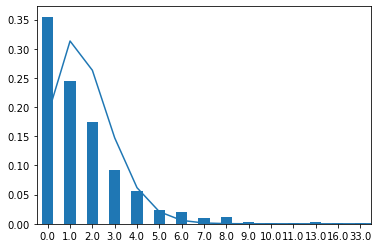

In [74]:
from scipy import stats
from scipy.stats import poisson

# nella distribuzione quante volte compare lo 0 per esempio

tmp = dfseries.sold
tmpv = tmp.value_counts(sort = False , normalize = True).sort_index()


mu = tmp.mean()
print(mu)
dist = stats.poisson(mu)

#print(dist)
x = np.arange(tmp.min(), tmp.max() +1)
#print(x)

tmpv.plot.bar()
series=pd.Series(index=x, data=dist.pmf(x))
series.plot()

#### Dataset prob neur model



In [75]:
import keras

In [76]:
i = ids[0]

In [77]:
sh = total_dict_sum[i]['1D'].shape[0]

sh = int(sh*0.8)

sep = total_dict_sum[i]['1D'].index[sh]

tr_data = total_dict_sum[i]['1D'][total_dict_sum[i]['1D'].index < sep]
ts_data = total_dict_sum[i]['1D'][total_dict_sum[i]['1D'].index >= sep]

In [1]:
tr_data

NameError: name 'tr_data' is not defined

In [78]:
X, y = keras.utils.to_categorical(tr_data.index.weekday.values), tr_data.values
X_test, y_test = keras.utils.to_categorical(ts_data.index.weekday.values), ts_data.values

In [79]:
X.shape

(1128, 7)

## Models

### Probabilistic Neural Model

In [80]:
import keras
from keras import layers
import tensorflow_probability as tfp

def build_probabilistic_regressor(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    log_rate = layers.Dense(1, activation='linear')(x)
    lf = lambda t: tfp.distributions.Poisson(log_rate=t, force_probs_to_zero_outside_support=False)
    model_out = tfp.layers.DistributionLambda(lf)(log_rate)
    model = keras.Model(model_in, model_out)
    return model

In [81]:
from keras import callbacks
nnpr = build_probabilistic_regressor(X.shape[1], hidden=[32])
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
nnpr.compile(optimizer='Adam', loss=negloglikelihood)
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history = nnpr.fit(X, y.astype(np.float32),validation_split=0.2, callbacks=cb, batch_size=32, epochs=150, verbose=1)



Epoch 1/150
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
29/29 [==============================] - 1s 7ms/step - loss: 2.0074 - val_loss: 2.1649
Epoch 2/150
29/29 [==============================] - 0s 2ms/step - loss: 1.9502 - val_loss: 2.1143
Epoch 3/150
29/29 [==============================] - 0s 2ms/step - loss: 1.9189 - val_loss: 2.0900
Epoch 4/150
29/29 [==============================] - 0s 2ms/step - loss: 1.9028 - val_loss: 2.0770
Epoch 5/150
29/29 [==============================] - 0s 2ms/step - loss: 1.8924 - val_loss: 2.0677
Epoch 6/150
29/29 [==============================] - 0s 2ms/step - loss: 1.8830 - val_loss: 2.0596
Epoch 7/150
29/29 [==============================] - 0s 2ms/step - loss: 1.8746 - val_loss: 2.0525
Epoch 8/150
29/29 [==============================] - 0s 2ms/step - loss: 1.8671 - val_loss: 2.0504
Epoch 9

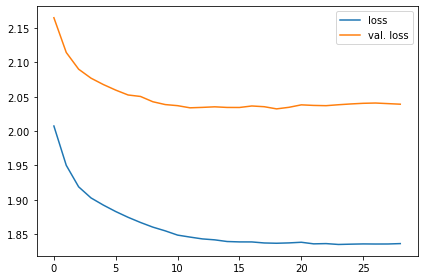

In [82]:
def plot_training_history(history, autoclose=True):
    if autoclose:
        plt.close('all')
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    if 'val_loss' in history.history.keys():
        plt.plot(history.history['val_loss'], label='val. loss')
        plt.legend()
    plt.tight_layout()


plot_training_history(history)

In [83]:
tr, vl = history.history["loss"][-1], np.min(history.history["val_loss"])
print(f'Loss: {tr:.4f} (training, final), {vl:.4f} (validation, best)')

Loss: 1.8364 (training, final), 2.0323 (validation, best)


In [84]:
def plot_pred_scatter(y_pred, y_true, autoclose=True):
    if autoclose:
        plt.close('all')
    plt.figure()
    plt.scatter(y_pred, y_true, marker='.', alpha=0.1)
    xl, xu = plt.xlim()
    yl, yu = plt.ylim()
    l, u = min(xl, yl), max(xu, yu)
    plt.plot([l, u], [l, u], ':', c='0.3')
    plt.xlim(l, u)
    plt.ylim(l, u)
    plt.xlabel('prediction')
    plt.ylabel('target')
    plt.tight_layout()

In [85]:
from sklearn import metrics

In [86]:
def rmse(pred, value):
    return np.sqrt(((pred-value)**2).mean())

In [2]:
#rmse without zeros

tr_preds = nnpr(X).mean()

print(f'MAE: {metrics.mean_absolute_error(y, tr_preds)}')


print('RMSE:', rmse(np.array(tr_preds), y))

NameError: name 'nnpr' is not defined

In [89]:
#rmse without zeros

ts_preds = nnpr(X_test).mean()

print(f'MAE: {metrics.mean_absolute_error(y_test, ts_preds)}')
print('RMSE:', rmse(np.array(ts_preds), y_test))

R2: 0.025834113931552993
MAE: 1.2746514081954956
1.878746


### Random Forest Regressor


In [90]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse


import joblib
import warnings
warnings.filterwarnings("ignore")

In [72]:
# Fitting Random Forest Regression to the dataset
# import the regressor
sh = int(X.shape[0] *0.8)
X_tr, X_val = X[:sh], X[sh:] 
y_tr, y_val = y[:sh], y[sh:] 

model_rf = RandomForestRegressor()
model_rf.fit(X_tr, y_tr)
#joblib.dump(model_rf2, "./random_forest.joblib")

RandomForestRegressor()

In [75]:
y_val_pred  = model_rf.predict(X_val)
rmse = mse(y_val, y_val_pred)
#print(rmse(y_val_pred, y_val))
print(rmse)
mae = metrics.mean_absolute_error(y_val, y_val_pred)
print(mae)

4.906264888369631
1.534323548782305


## Adding some Features

We can add some features at the dataset. Usually the features that are added are:
- Lag Features
- Mean of the Features
- Rolling

#### Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

We can simply add lags related to the the target variable (the 'sold' column).

In [ ]:
df2 = df.copy()

In [ ]:
print(df2)

df.groupby([list])['column'].operation()
raggruppa gli elementi in base alla lista, e aggrega i dati della colonna facendo l'operation su quei dati della colonna. Scrive 


In [ ]:
# Introduce lags

lags = [1, 2, 3, 6, 7, 14, 21, 28, 35, 42, 49, 60, 70]
for lag in lags:
    # group each row based on this columns, and then we shift the value of the lag. The column 'id' is a unique value that represent
    # all this columns ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    df2['sold_lag_'+str(lag)] = df2.groupby(['id'],as_index=False)['sold'].shift(lag).astype(np.float16)

In [ ]:
print(df2.shape)

In [ ]:
print(df2.head())

#### Mean Encoding

Mean encoding represents a probability of our target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value. We add some mean related to this elements:

item

state

store

category

department

category & department

store & item

category & item

department & item

state & store

state, store and category

store, category and department


If we use df2['store_sold_avg'] = df2.groupby('store_id')['sold'].mean().astype(np.float16), we obtain 10 values that are the mean values of each store id.
We want to broadcast these values. We can use easily transform for that.
https://towardsdatascience.com/pandas-transform-more-than-meets-the-eye-928542b40b56

We want the mean of the sells of each item. We can group by the column item_id and then divide by the number of row in each group

|       item_id	    | d  | sold   |
|---------------|:----:|------:|
| 388 | 1 | 6 |
| 388 | 2 | 5 |
| 388 | 3 | 2 |
| 388 | 4 | 0 |

We obtain the "item_sold_avg" that is the mean of the 4 values with the same item_id (13/4).


In [ ]:
df2['item_sold_avg'] = df2.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df2['state_sold_avg'] = df2.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df2['store_sold_avg'] = df2.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df2['cat_sold_avg'] = df2.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df2['dept_sold_avg'] = df2.groupby('dept_id')['sold'].transform('mean').astype(np.float16)


We can group also depending to two columns: we group by dept_id and cat_id and then divide by the number of row in each group


|       id	    | dept_id | cat_id |  sold   |
|---------------|:----:|:----:|------:|
| 3880 | 1 | 0 | 6 |
| 3890 | 1 | 0 | 0 |
| 3900 | 1 | 0 | 2 |
| 3910 | 1 | 0 | 0 |
| 3920 | 1 | 0 | 0 |
| 27158 | 6 | 2 | 0 |
| 27168 | 6 | 2 | 1 |
| 27178 | 6 | 2 | 0 |
| 27188 | 6 | 2 | 0 |
| 27198 | 6 | 2 | 0 |

the cat_dept_sold_avg will give us 1.599 for the first five row, 0.199 for the last five.
(6+2)/5 = 1.599
1/5 = 0.199


In [ ]:

df2['cat_dept_sold_avg'] = df2.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df2['store_item_sold_avg'] = df2.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df2['cat_item_sold_avg'] = df2.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df2['dept_item_sold_avg'] = df2.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df2['state_store_sold_avg'] = df2.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df2['state_store_cat_sold_avg'] = df2.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df2['store_cat_dept_sold_avg'] = df2.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [ ]:
df2.shape

In [ ]:
df2.head(5)

#### Rolling average

I'll be calculating weekly rolling avearge of the items sold. 
More features like rolling min, max or sum can also be calculated. 
Also, same features can be calculated for revenue as well (nel caso da aggiungere in alto)

https://pandas.pydata.org/docs/user_guide/window.html#window-expanding

The rolling().mean() method. In this way we calculate the mean of the values that are in a given window. rolling(2).mean() consider two elements of the series and do the mean. Then shift the window of one index.

For instance given this series and rolling(window = 2).mean():


|       index	    | value |
|--------|------:|
|0 |   1.0 |
|1 |   3.0 |
|2 |   5.0 |
|3 |   NaN |
|4 |   7.0 |
|5 |   9.0 |

Result (the mean of the window values):
|       index	    | value | (Operation) |
|--------|:------:|------:
|0 |   NaN | only one value, we need two |
|1 |   2.0 | (1+3)/2 |
|2 |   4.0 | (3+5)/2 |
|3 |   NaN | we can't divide NaN |
|4 |   NaN | we can't divide NaN  |
|5 |   8.0 | (7+9)/2 |

Note: NaN is not considered as value. If we put 0 change the result.


In [ ]:
# in theory 'id' takes into account all this columns [ 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
windows = [7, 28]
for window in windows:
    df2['rolling_sold_mean_'+str(window)] = df2.groupby(['id'])['sold'].transform(lambda x: x.rolling(window=window).mean()).astype(np.float16)

In [ ]:
df2.head()

In [ ]:
df2.shape

The expanding() method. It is similar to the rolling, but in this method we calculate the cumulative mean of entire series elements using expanding() method and mean function.

For instance given this series:


|       index	    | value |
|--------|------:|
|0 |   1.0 |
|1 |   3.0 |
|2 |   5.0 |
|3 |   NaN |
|4 |   7.0 |
|5 |   9.0 |

Result (the mean of the cumulative value):
|       index	    | value | (Operation) |
|--------|:------:|------:
|0 |   1.0 | 1/1 |
|1 |   2.0 | (1+3)/2 |
|2 |   3.0 | (1+3+5)/3 |
|3 |   3.0 | (1+3+5+NaN)/3 |
|4 |   4.0 | (1+3+5+NaN+7)/4 |
|5 |   5.0 | (1+3+5+NaN+7+9)/5 |

Note: NaN is not considered as value. If we put 0 change the result.
In the previous example we obtain a cumulative value and the minimum number of value that we can consider is 1 (by default). If we use expanding(2) we consider at least two elements in order to calculate the mean. 


Result (the mean of the cumulative value):
|       index	    | value | (Operation) |
|--------|:------:|------:
|0 |   NaN | only one value, we need two |
|1 |   2.0 | (1+3)/2 |
|2 |   3.0 | (1+3+5)/3 |
|3 |   3.0 | (1+3+5+NaN)/3 |
|4 |   4.0 | (1+3+5+NaN+7)/4 |
|5 |   5.0 | (1+3+5+NaN+7+9)/5 |

In [ ]:
df2['expanding_sold_mean'] = df2.groupby(['id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

#### Trend


We can create a selling trend feature, which will be some positive value if the daily items sold are greater than the entire duration average ( d_1 - d_1941 ) else negative.


In [ ]:
# we take into account the id of the product and the day and we calculate the mean of the sold products (in the given day)
df2['daily_avg_sold'] = df2.groupby(['id','d'])['sold'].transform('mean').astype(np.float16)
# then we we take into account only the id and we calculate the mean of the sold products (in general)
df2['avg_sold'] = df2.groupby(['id'])['sold'].transform('mean').astype(np.float16)
# doing the difference we see if there is a trend positive or negative respect to the mean.
df2['selling_trend'] = (df2['daily_avg_sold'] - df2['avg_sold']).astype(np.float16)


In [ ]:
from matplotlib import pyplot
pyplot.plot(df2['daily_avg_sold'][:150])
pyplot.plot(df2['avg_sold'][:150], color='red')

In [ ]:
pyplot.plot(df2['selling_trend'][:150])

In [ ]:
df2.drop(['daily_avg_sold','avg_sold'], axis=1, inplace = True)

### Save the data


We have lags that introduce some NaN values. We can remove the first days in order to reduce this problem.

In [ ]:
df2[df2.columns[:30]].head()

In [ ]:
df2 = df2[df2['d']>lags[-1]] 

In [ ]:
df2[df2.columns[:30]].head()

Let's look at our new dataframe.

In [ ]:
for column in df2.columns:
    if df2[column].isnull().sum() != 0:
        print('number of values that are NaN in the column', column, df2[column].isnull().sum())

Save the data for training.

In [ ]:
import gc


df2.to_pickle('data.pkl')
del df, df2
gc.collect()